In [1]:
# RNN 24 séquences sans permutation

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
os.listdir('data')

['Env_QH.csv',
 'micro_sud3.pkl',
 'AllPM_QH.csv',
 'micro_sud3_normalized.pkl',
 'AllNO2_QH.csv']

In [3]:
df = pd.read_pickle('data/micro_sud3_normalized.pkl')
df = df.reset_index()

def split_dataframe(dataframe, percent):
    nb_rows = int(np.floor(percent * len(dataframe)))
    return dataframe[:nb_rows], dataframe[nb_rows:]

def dataframe_to_xy(df, look_back):
    i = look_back
    while True:
        sequence = df.iloc[i - look_back:i]
        yield np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8) , np.array(sequence['NO2_ref'])
        i += 1
        if i == len(df):
            i = look_back
            
def dataframe_to_xy_test(df, look_back):
    X_test, y_test = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X_test.append(np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8))
        y_test.append(np.array(df.iloc[i]['NO2_ref']))
        i += 1
        if i == len(df):
            break
            
    return np.array(X_test), np.array(y_test)
            
        
df_test, df_train = split_dataframe(df, 0.5) 
df_valid, df_test = split_dataframe(df_test, 0.5)

X_train = dataframe_to_xy(df_train, 10)
X_valid = dataframe_to_xy(df_valid, 10)
X_test, y_test = dataframe_to_xy_test(df_test, 10)

In [4]:
def dataframe_to_xy_no_generator(df, look_back):
    X, y = [], []
    i = look_back
    while i < len(df):
        sequence = df.iloc[i - look_back:i]
        X.append(np.array(sequence[['NO2_61FD', 'NO2_61F0', 'NO2_61EF', 'temp', 'rh',\
                                 'tgrad', 'pressure', 'pluvio']]).reshape(look_back, 1, 8))
        y.append(np.array(df.iloc[i]['NO2_ref']))
        i += 1
        if i == len(df):
            break
    X = np.array(X)
    y = np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], X.shape[3]))
    return X, y

In [5]:
X_train, y_train = dataframe_to_xy_no_generator(df_train, 24)
X_valid, y_valid = dataframe_to_xy_no_generator(df_valid, 24)
X_test, y_test = dataframe_to_xy_no_generator(df_test, 24)

In [10]:
from keras.layers import SimpleRNN, Dense, LSTM, GRU
from keras.models import Sequential
from keras.callbacks import EarlyStopping

def simple_rnn_model(nb_units, input_dim, loss='mean_squared_error', optimizer='rmsprop'):
    model = Sequential()
    model.add(SimpleRNN(nb_units, input_shape=input_dim))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def lstm_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(nb_units, input_shape=input_dim))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

def gru_model(nb_units, input_dim, loss='mean_squared_error', optimizer='adam'):
    model = Sequential()
    model.add(GRU(nb_units, input_shape=input_dim))
    model.add(Dense(nb_units, activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer)
    model.summary()
    return model

%matplotlib inline

In [11]:
model = simple_rnn_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 32)                1312      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 2,401
Trainable params: 2,401
Non-trainable params: 0
_________________________________________________________________


In [12]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1 ,shuffle=True)

Train on 1103 samples, validate on 539 samples
Epoch 1/5000
1103/1103 [==============================] - 1s - loss: 2106.0584 - val_loss: 2667.9428
Epoch 2/5000
1103/1103 [==============================] - 0s - loss: 1976.8817 - val_loss: 2492.3807
Epoch 3/5000
1103/1103 [==============================] - 0s - loss: 1788.1243 - val_loss: 2247.5564
Epoch 4/5000
1103/1103 [==============================] - 0s - loss: 1552.0804 - val_loss: 1961.6409
Epoch 5/5000
1103/1103 [==============================] - 0s - loss: 1301.8472 - val_loss: 1641.5949
Epoch 6/5000
1103/1103 [==============================] - 0s - loss: 1082.2824 - val_loss: 1393.1230
Epoch 7/5000
1103/1103 [==============================] - 0s - loss: 934.9633 - val_loss: 1236.2999
Epoch 8/5000
1103/1103 [==============================] - 0s - loss: 834.7685 - val_loss: 1154.9465
Epoch 9/5000
1103/1103 [==============================] - 0s - loss: 764.9203 - val_loss: 1099.1344
Epoch 10/5000
1103/1103 [======================

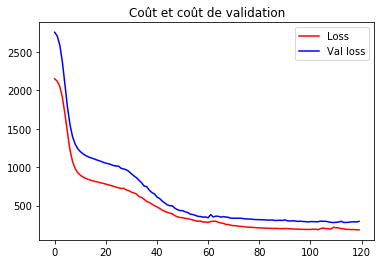

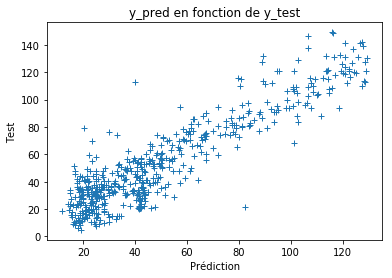

In [9]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [10]:
model = lstm_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5248      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 6,337
Trainable params: 6,337
Non-trainable params: 0
_________________________________________________________________


In [11]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1103 samples, validate on 539 samples
Epoch 1/5000
1103/1103 [==============================] - 1s 1ms/step - loss: 2158.1391 - val_loss: 2773.9104
Epoch 2/5000
1103/1103 [==============================] - 0s 433us/step - loss: 2139.1705 - val_loss: 2739.3523
Epoch 3/5000
1103/1103 [==============================] - 0s 426us/step - loss: 2075.6451 - val_loss: 2616.0789
Epoch 4/5000
1103/1103 [==============================] - 0s 428us/step - loss: 1881.1780 - val_loss: 2295.7120
Epoch 5/5000
1103/1103 [==============================] - 0s 424us/step - loss: 1505.9102 - val_loss: 1758.8641
Epoch 6/5000
1103/1103 [==============================] - 0s 425us/step - loss: 1106.6164 - val_loss: 1340.8436
Epoch 7/5000
1103/1103 [==============================] - 0s 424us/step - loss: 925.6381 - val_loss: 1199.7463
Epoch 8/5000
1103/1103 [==============================] - 0s 423us/step - loss: 860.5972 - val_loss: 1145.4834
Epoch 9/5000
1103/1103 [==============================] - 0s 

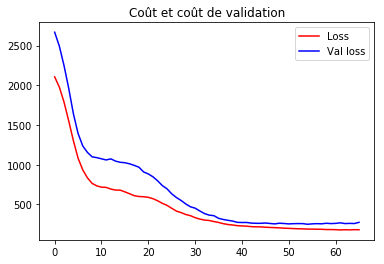

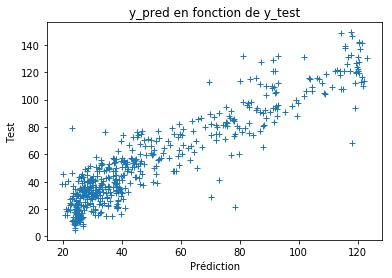

In [13]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()

In [13]:
model = gru_model(32, X_train.shape[1:])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                3936      
_________________________________________________________________
dense_5 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 5,025
Trainable params: 5,025
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, mode='auto', patience=10)
history = model.fit(X_train, y_train, batch_size=32, epochs=5000, validation_data=(X_valid, y_valid), callbacks=[early_stopping], verbose=1, shuffle=False)

Train on 1103 samples, validate on 539 samples
Epoch 1/5000
1103/1103 [==============================] - 1s 1ms/step - loss: 2157.5395 - val_loss: 2771.6779
Epoch 2/5000
1103/1103 [==============================] - 0s 357us/step - loss: 2137.5855 - val_loss: 2743.4313
Epoch 3/5000
1103/1103 [==============================] - 0s 357us/step - loss: 2089.4976 - val_loss: 2656.5223
Epoch 4/5000
1103/1103 [==============================] - 0s 367us/step - loss: 1926.0092 - val_loss: 2349.1915
Epoch 5/5000
1103/1103 [==============================] - 0s 357us/step - loss: 1623.7299 - val_loss: 1871.9016
Epoch 6/5000
1103/1103 [==============================] - 0s 355us/step - loss: 1250.6148 - val_loss: 1440.7659
Epoch 7/5000
1103/1103 [==============================] - 0s 362us/step - loss: 983.8517 - val_loss: 1200.9613
Epoch 8/5000
1103/1103 [==============================] - 0s 373us/step - loss: 840.7496 - val_loss: 1105.9832
Epoch 9/5000
1103/1103 [==============================] - 0s 

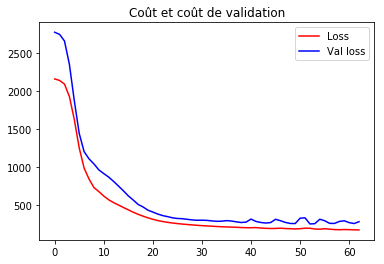

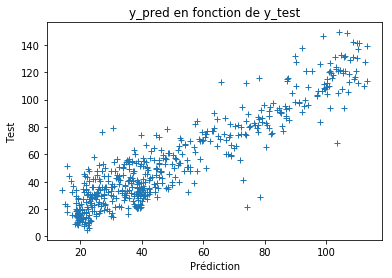

In [15]:
y_pred = model.predict(X_test)
plt.title('Coût et coût de validation')
line1,=plt.plot(history.history['loss'], label="Loss", linestyle='-', color='r')
line2,=plt.plot(history.history['val_loss'], label="Val loss", linestyle='-', color='b')
first_legend = plt.legend(handles=[line1, line2], loc=1)

plt.show()

plt.title('y_pred en fonction de y_test')

plt.plot(y_pred[:], y_test[:], '+')
plt.ylabel('Test')
plt.xlabel('Prédiction')
plt.show()